## Question 4

### Electric Field of a Sphere

From Griffiths, the integral we are interested in evaluating is:

$$E_z = \frac{1}{4\pi\epsilon_0} \sigma R^2 2\pi \int^{\pi}_0\frac{z - Rcos\theta}{(R^2 + z^2 -2Rzcos\theta)^{3/2}} \space sin\theta \space d\theta$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize

In [2]:
#Set up variables

R = 5
z = np.linspace(0, 2*R, 1000)
theta = np.linspace(0, np.pi, 1000)

#Set sigma, epsilon to 1.0... We just want the functional form. 

#Function to integrate
def func(theta, z):
    return ((z - R*np.cos(theta))/(R**2 + z**2 - 2*R*z*np.cos(theta))**(3/2))*np.sin(theta)

scipy.optimize.root_scalar?

Object `scipy.optimize.root_scalar` not found.


In [3]:

#For quad
E_quad = np.zeros(len(z))
E_quad_err = np.zeros(len(z))
for i, valz in enumerate(z):
    E_quad[i] = (1/(4*np.pi))*2*np.pi*R**2 * scipy.integrate.quad(func, 0, np.pi, args=valz)[0]
    E_quad_err[i] = (1/(4*np.pi))*2*np.pi*R**2 * scipy.integrate.quad(func, 0, np.pi, args=valz)[1] #Errors



/home/soud/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


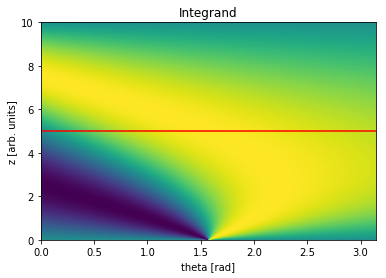

In [4]:
#Plotting, red line denotes R
X = np.zeros([len(theta), len(z)])
for c1, t in enumerate(theta):
    for c2, zz in enumerate(z):
        X[c1, c2] = func(t, zz)


    
plt.imshow(X, label = 'integrand', extent=[0,np.pi,0,z[-1]], aspect = 'auto', origin='lower')
plt.axhline(y=R, color='red')
plt.title('Integrand')
plt.xlabel('theta [rad]')
plt.ylabel('z [arb. units]')
plt.legend()

#Aha! A pole at theta = pi, z = 0.


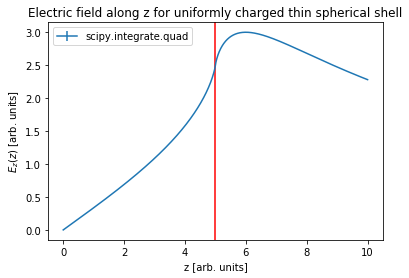

In [5]:
#Plotting, red line denotes R
plt.errorbar(z, E_quad, yerr = E_quad_err, label = 'scipy.integrate.quad')
plt.axvline(x=R, color='red')
plt.title('Electric field along z for uniformly charged thin spherical shell')
plt.xlabel('z [arb. units]')
plt.ylabel(r'$E_z(z)$ [arb. units]')
plt.legend()

In [21]:
#New class here for "smarter" integration with less function calls


def less_simple_integrate(fun,a,b,z,tol, lr="none", y_old=np.zeros(5)): #Doesn't call fun(x) multiple times for same x
    theta=np.linspace(a,b,5)
    #dx=(b-a)/4.0
    y=np.zeros(5)
    neval=0
    #print(y)
    #print(y_old)
    if lr == "l":
        y[0] = y_old[0] #Left bound is the same
        y[2] = y_old[1] #We can carry the mid over
        y[4] = y_old[2] #Old mid is now right bound
        y[1] = fun(theta[1], z)
        y[3] = fun(theta[3], z)
        neval +=2
    elif lr == "r":
        y[0] = y_old[2] #Old mid is the new left bound
        y[4] = y_old[4] #Right bound is the same 
        y[2] = y_old[3]
        y[1] = fun(theta[1],z)
        y[3] = fun(theta[3],z)
        neval+=2
    else:
        for i, val in enumerate(theta):
            y[i] = fun(val, z)
        neval+=5


    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a)
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a)

    myerr=np.abs(f2-f1)

    #print([a,b,f1,f2])
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval
    else:
        mid=0.5*(b+a)
        
        f_right,err_right,neval_right=less_simple_integrate(fun,theta[2],theta[4],tol/2.0, "r", y)
        f_left,err_left,neval_left=less_simple_integrate(fun,theta[0],theta[2],tol/2.0, "l", y)
        

        neval=neval+neval_left+neval_right

        f=f_left+f_right
        err=err_left+err_right

        return f,err,neval


In [33]:
#For less_simple_integrator
E_lsi = np.zeros(len(z))
E_lsi_err = np.zeros(len(z))
for i, valz in enumerate(z):
    E_lsi[i] = (1/(4*np.pi))*2*np.pi*R**2 * less_simple_integrate(func, 0, np.pi, valz, 1e-8)[0]
    E_lsi_err[i] = (1/(4*np.pi))*2*np.pi*R**2 * less_simple_integrate(func, 0, np.pi, valz, 1e-8)[1] #Errors


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error


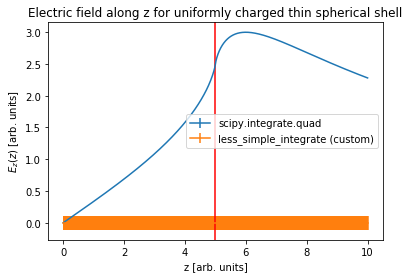

In [34]:
#Plotting, red line denotes R
plt.errorbar(z, E_quad, yerr = E_quad_err, label = 'scipy.integrate.quad')
plt.errorbar(z, E_lsi, yerr = E_lsi_err, label = 'less_simple_integrate (custom)')
plt.axvline(x=R, color='red')
plt.title('Electric field along z for uniformly charged thin spherical shell')
plt.xlabel('z [arb. units]')
plt.ylabel(r'$E_z(z)$ [arb. units]')
plt.legend()